# Homework 3 - Berkeley STAT 157

Handout 2/5/2019, due 2/12/2019 by 4pm in Git by committing to your repository.

**Formatting: please include both a .ipynb and .pdf file in your homework submission, named homework3.ipynb and homework3.pdf. You can export your notebook to a pdf either by File -> Download as -> PDF via Latex (you may need Latex installed), or by simply printing to a pdf from your browser (you may want to do File -> Print Preview in jupyter first). Please don't change the filename.**       

In [3]:
from mxnet import nd, autograd, gluon, init
from mxnet.gluon import data as gdata
from mxnet.gluon import nn
from mxnet.gluon import loss as gloss
import matplotlib.pyplot as plt

# 1. Logistic Regression for Binary Classification

In multiclass classification we typically use the exponential model 

$$p(y|\mathbf{o}) = \mathrm{softmax}(\mathbf{o})_y = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$

1.1. Show that this parametrization has a spurious degree of freedom. That is, show that both $\mathbf{o}$ and $\mathbf{o} + c$ with $c \in \mathbb{R}$ lead to the same probability estimate.

1.2. For binary classification, i.e. whenever we have only two classes $\{-1, 1\}$, we can arbitrarily set $o_{-1} = 0$. Using the shorthand $o = o_1$ show that this is equivalent to 

$$p(y=1|o) = \frac{1}{1 + \exp(-o)}$$

1.3. Show that the log-likelihood loss (often called logistic loss) for labels $y \in \{-1, 1\}$ is thus given by 

$$-\log p(y|o) = \log (1 + \exp(-y \cdot o))$$

1.4. Show that for $y = 1$ the logistic loss asymptotes to $o$ for $o \to \infty$ and to $\exp(o)$ for $o \to -\infty$. 
### Answers
1.1. We can show that $p(y|\vec{o})=p(y|\vec{o}+c)$
    \begin{aligned}
        p(y|\vec{o}+c)&=\text{softmax}(\vec{o}+c)_y\\
        &=\frac{\exp(o_y+c)}{\sum_{y'}\exp(o_{y'}+c)}\\
        &=\frac{\exp(o_y)}{\sum_{y'}\exp(o_{y'})}\\
        &=p(y|\vec{o})
    \end{aligned}
1.2. 
    \begin{aligned}
        p(y=1|o)&=\frac{\exp(o)}{\exp(o_{-1})+\exp(o)}\\
        &=\frac{\exp(o)}{\exp(0)+\exp(o)}\\
        &=\frac{\exp(o)}{1+\exp(o)}\\
        &=\frac{1}{1+\exp(-o)}
    \end{aligned}
1.3. By the same method shown above, we can obtain that
    \begin{aligned}
        -\log p(y|o_{-1})=\frac{1}{1+\exp(o)}.
    \end{aligned}
    Therefor, the logistic loss is given by
    \begin{aligned}
        \text{for $y=-1$, }
        -\log p(y|o)&=-\log p(y=-1|o)\\
        &=-\log\left(\frac{1}{1+\exp(o)}\right)\\
        &=-\log\left(1+\exp(o)\right)\\
        \text{for $y=1$, }\\
        -\log p(y|o)&=-\log p(y=1|o)\\
        &=-\log\left(\frac{1}{1+\exp(-o)}\right)\\
        &=-\log\left(1+\exp(-o)\right)\\
        \therefore -\log p(y|o)&=\log\left(1+\exp(-y\cdot o)\right)
    \end{aligned}
1.4. For $y=1$,
    \begin{aligned}
        -\log p(y|o)&=\log\left(1+\exp(-o)\right)\\
        o\rightarrow\infty, \exp(-o)\rightarrow 0, &\log(1+\exp(-o))\rightarrow \exp(-o)
    \end{aligned}

# 2. Logistic Regression and Autograd

1. Implement the binary logistic loss $l(y,o) = \log (1 + \exp(-y \cdot o))$ in Gluon
1. Plot its values for $y \in \{-1, 1\}$ over the range of $o \in [-5, 5]$.
1. Plot its derivative with respect to $o$ for $o \in [-5, 5]$ using 'autograd'.

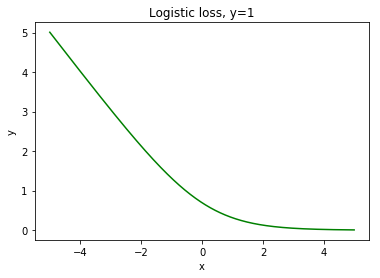

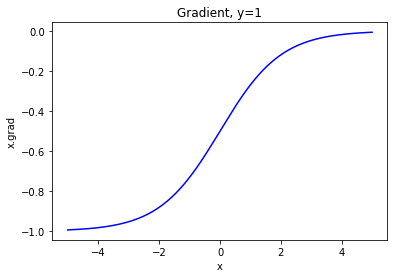

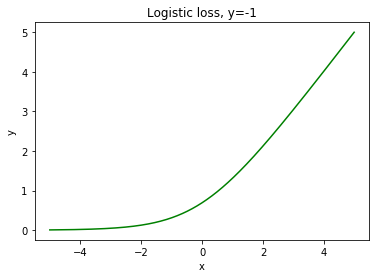

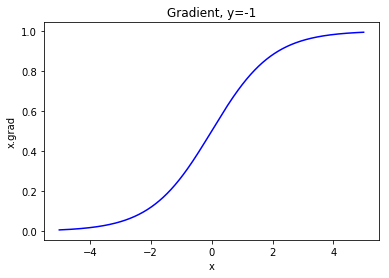

In [4]:
# Logistic loss
def loss(y,o):
    ## add your loss function here
    l = nd.log(1+nd.exp(-y*o))
    return l
o = nd.arange(-5, 5, 0.01)
o.attach_grad()
# for y = 1
y = nd.ones(shape = o.shape)
with autograd.record():
    l = loss(y, o)
l.backward()
# for loss function
plt.figure()
plt.title('Logistic loss, y=1')
plt.plot(o.asnumpy(), l.asnumpy(), color = 'g')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# for grad
plt.figure()
plt.title('Gradient, y=1')
plt.plot(o.asnumpy(), o.grad.asnumpy(), color = 'b')
plt.xlabel('x')
plt.ylabel('x.grad')
plt.show()
# for y = -1
y = -y
with autograd.record():
    l = loss(y, o)
l.backward()
# for loss function
plt.figure()
plt.title('Logistic loss, y=-1')
plt.plot(o.asnumpy(), l.asnumpy(), color = 'g')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# for grad
plt.figure()
plt.title('Gradient, y=-1')
plt.plot(o.asnumpy(), o.grad.asnumpy(), color = 'b')
plt.xlabel('x')
plt.ylabel('x.grad')
plt.show()

# 3. Ohm's Law

Imagine that you're a young physicist, maybe named [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm), trying to figure out how current and voltage depend on each other for resistors. You have some idea but you aren't quite sure yet whether the dependence is linear or quadratic. So you take some measurements, conveniently given to you as 'ndarrays' in Python. They are indicated by 'current' and 'voltage'.

Your goal is to use least mean squares regression to identify the coefficients for the following three models using automatic differentiation and least mean squares regression. The three models are:

1. Quadratic model where $\mathrm{voltage} = c + r \cdot \mathrm{current} + q \cdot \mathrm{current}^2$.
1. Linear model where $\mathrm{voltage} = c + r \cdot \mathrm{current}$.
1. Ohm's law where $\mathrm{voltage} = r \cdot \mathrm{current}$.

In [56]:
current = nd.array([1.5420291, 1.8935232, 2.1603365, 2.5381863, 2.893443, \
                    3.838855, 3.925425, 4.2233696, 4.235571, 4.273397, \
                    4.9332876, 6.4704757, 6.517571, 6.87826, 7.0009003, \
                    7.035741, 7.278681, 7.7561755, 9.121138, 9.728281])
voltage = nd.array([63.802246, 80.036026, 91.4903, 108.28776, 122.781975, \
                    161.36314, 166.50816, 176.16772, 180.29395, 179.09758, \
                    206.21027, 272.71857, 272.24033, 289.54745, 293.8488, \
                    295.2281, 306.62274, 327.93243, 383.16296, 408.65967])

batch_size = 5
# for Voltage = I * r + I * q^2 + c
current_squared = current ** 2
# current1 = nd.concat(current, current_squared, dim = 0)
# Integrated data: [I, I^2]
current1 = current.reshape(len(current), 1)
current1 = nd.concat(current1, current_squared.reshape(len(current_squared), 1), dim=1)

model_name = [r'V=I*r+I^2*q+c', 'V=I*r', 'V=I*r+c']
def regression(current, voltage, model_type, learning_rate=0.03):
    dataset = gdata.ArrayDataset(current, voltage)
    data_iter = gdata.DataLoader(dataset, batch_size, shuffle = True)
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    loss = gloss.L2Loss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})
    num_epochs = 4
    for epoch in range(0, num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        l = loss(net(current), voltage)
        print('epoch %d, loss: %f' % (epoch+1, l.mean().asscalar()))
    w = net[0].weight.data()
    b= net[0].bias.data()
    plt.figure()
    if model_type == 0:
        current_plot = current[:,0]
    else:
        current_plot = current
    if model_type == 1:
        plt.plot(current_plot.asnumpy(), (w*current).reshape(voltage.shape).asnumpy(),\
                 color = 'b', label = 'Predicated')
    else:
        plt.plot(current_plot.asnumpy(), (w*current+b).reshape(voltage.shape).asnumpy(),\
                 color = 'b', label = 'Predicated')
    plt.plot(current_plot.asnumpy(), voltage.asnumpy(), color = 'r', label = 'Realistic')
    plt.legend(loc = 'upper left')
    plt.title(model_name[model_type])
    plt.show()

epoch 1, loss: 7223.753906
epoch 2, loss: 7553.661621
epoch 3, loss: 20598.761719
epoch 4, loss: 10804.008789


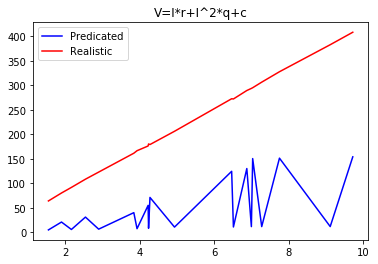

epoch 1, loss: 3.716232
epoch 2, loss: 3.716024
epoch 3, loss: 3.140820
epoch 4, loss: 3.160908


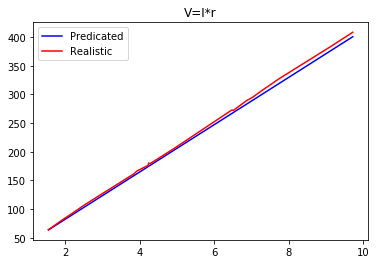

epoch 1, loss: 52.245838
epoch 2, loss: 3.752758
epoch 3, loss: 5.298982
epoch 4, loss: 2.827415


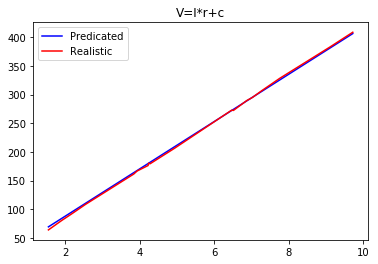

In [57]:
regression(current1, voltage, model_type=0, learning_rate = 0.001)
regression(current, voltage, model_type=1)
regression(current, voltage, model_type=2)

# 4. Entropy

Let's compute the *binary* entropy of a number of interesting data sources. 

1. Assume that you're watching the output generated by a [monkey at a typewriter](https://en.wikipedia.org/wiki/File:Chimpanzee_seated_at_typewriter.jpg). The monkey presses any of the $44$ keys of the typewriter at random (you can assume that it has not discovered any special keys or the shift key yet). How many bits of randomness per character do you observe?
1. Unhappy with the monkey you replaced it by a drunk typesetter. It is able to generate words, albeit not coherently. Instead, it picks a random word out of a vocabulary of $2,000$ words. Moreover, assume that the average length of a word is $4.5$ letters in English. How many bits of randomness do you observe now?
1. Still unhappy with the result you replace the typesetter by a high quality language model. These can obtain perplexity numbers as low as 20 points per character. The perplexity is defined as a length normalized probability, i.e.

$$\mathrm{PPL}(x) = \left[p(x)\right]^{1/\mathrm{length}(x)}$$
### Answers
1. The random bits per character is $\log_2 44\approx 5.46$.
2. The possible outcomes in regard of words is $2,000$. Hence there are $\log_2 2,000$ random bits per word. The random bits per character is thus $\log_2 2,000\div 4.5\approx 2.44$.
3. $\log_2 20\approx 4.32$

# 5. Wien's Approximation for the Temperature (bonus)

We will now abuse Gluon to estimate the temperature of a black body. The energy emanated from a black body is given by Wien's approximation.

$$B_\lambda(T) = \frac{2 h c^2}{\lambda^5} \exp\left(-\frac{h c}{\lambda k T}\right)$$

That is, the amount of energy depends on the fifth power of the wavelength $\lambda$ and the temperature $T$ of the body. The latter ensures a cutoff beyond a temperature-characteristic peak. Let us define this and plot it.

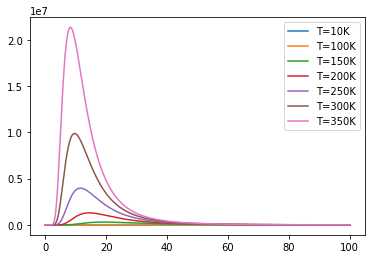

In [6]:
# Lightspeed
c = 299792458
# Planck's constant
h = 6.62607004e-34
# Boltzmann constant
k = 1.38064852e-23
# Wavelength scale (nanometers)
lamscale = 1e-6
# Pulling out all powers of 10 upfront
p_out = 2 * h * c**2 / lamscale**5
p_in = (h / k) * (c/lamscale) 

# Wien's law
def wien(lam, t):
    return (p_out / lam**5) * nd.exp(-p_in / (lam * t))

# Plot the radiance for a few different temperatures
lam = nd.arange(0,100,0.01)
for t in [10, 100, 150, 200, 250, 300, 350]:
    radiance = wien(lam, t)
    plt.plot(lam.asnumpy(), radiance.asnumpy(), label=('T=' + str(t) + 'K'))
plt.legend()
plt.show()

Next we assume that we are a fearless physicist measuring some data. Of course, we need to pretend that we don't really know the temperature. But we measure the radiation at a few wavelengths.  

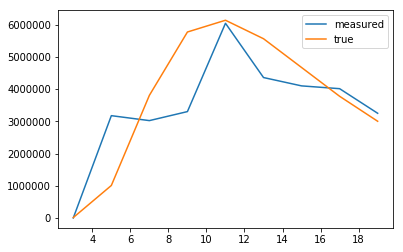

In [7]:
# real temperature is approximately 0C
realtemp = 273
# we observe at 3000nm up to 20,000nm wavelength
wavelengths = nd.arange(3,20,2)
# our infrared filters are pretty lousy ...
delta = nd.random_normal(shape=(len(wavelengths))) * 1

radiance = wien(wavelengths + delta, realtemp)
plt.plot(wavelengths.asnumpy(), radiance.asnumpy(), label='measured')
plt.plot(wavelengths.asnumpy(), wien(wavelengths, realtemp).asnumpy(), label='true')
plt.legend()
plt.show()

Use Gluon to estimate the real temperature based on the variables `wavelengths` and `radiance`. 

* You can use Wien's law implementation `wien(lam,t)` as your forward model. 
* Use the loss function $l(y,y') = (\log y - \log y')^2$ to measure accuracy.